# Initial Comparison

We run integrated gradients and activation patching on the same model and dataset, to compare attribution scores.

- Model: GPT2-Small (12 layers, 12 attention heads per layer, embedding size 768, 3,072 neurons per MLP layer)
- Dataset: Indirect Object Identification task

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.utils import get_device

from attribution_methods import activation_patching, highlight_components, integrated_gradients
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap
from plotting import plot_attn_comparison, plot_correlation_comparison, plot_mean_diff

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Experiment

In [ ]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1513,  1.7507], device='cuda:0', grad_fn=<SubBackward0>)
Corrupted logit difference: tensor([-0.0387, -0.9451, -0.5103,  2.2153,  0.6299, -3.2074, -0.1823,  1.1766,
        -3.0072,  1.7392], device='cuda:0', grad_fn=<SubBackward0>)


In [11]:
zero_baseline_cache_dict = dict()
for k, v in clean_cache.cache_dict.items():
    zero_baseline_cache_dict[k] = torch.zeros_like(v)
zero_baseline_cache = ActivationCache(zero_baseline_cache_dict, model)

ig_mlp_results, ig_attn_results = integrated_gradients(
    model,
    clean_tokens,
    zero_baseline_cache,
    clean_cache,
    logit_diff_metric,
    labels,
)


# from transformer_lens.utils import get_act_name
# from attribution_methods import compute_layer_to_output_attributions

# torch.set_grad_enabled(True)

# # Standard integrated gradients with zero baseline

# n_samples = clean_tokens.size(0)

# ig_mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
# ig_attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

# # Calculate integrated gradients for each layer
# for layer in range(model.cfg.n_layers):

#     # Gradient attribution on heads
#     hook_name = get_act_name("result", layer)
#     target_layer = model.hook_dict[hook_name]
#     prev_layer_hook = get_act_name("z", layer)
#     prev_layer = model.hook_dict[prev_layer_hook]

#     # Use zero activations as the corrupt
#     layer_input = torch.zeros_like(layer_input)
#     layer_baseline = clean_cache[prev_layer_hook]

#     # Shape [batch, seq_len, d_head, d_model]
#     attributions = compute_layer_to_output_attributions(
#         model,
#         clean_tokens,
#         layer_input,
#         layer_baseline,
#         target_layer,
#         prev_layer,
#         logit_diff_metric,
#         labels,
#     )

#     # Calculate score based on mean over each embedding, for each token
#     per_token_score = attributions.mean(dim=3)
#     score = per_token_score.mean(dim=1)
#     ig_attn_results[:, layer] = score

#     # Gradient attribution on MLP neurons
#     hook_name = get_act_name("post", layer)
#     target_layer = model.hook_dict[hook_name]
#     prev_layer_hook = get_act_name("mlp_in", layer)
#     prev_layer = model.hook_dict[prev_layer_hook]

#     layer_input = clean_cache[prev_layer_hook]
#     layer_baseline = torch.zeros_like(layer_input)

#     # Shape [batch, seq_len, d_model]
#     attributions = compute_layer_to_output_attributions(
#         model,
#         clean_tokens,
#         layer_input,
#         layer_baseline,
#         target_layer,
#         prev_layer,
#         logit_diff_metric,
#         labels,
#     )
#     score = attributions.mean(dim=1)
#     ig_mlp_results[:, layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-0.2312,  0.0361, -0.3072,  0.2132,  0.1879, -0.4308, -0.3752,  0.2711,
         4.4689, -0.1115], device='cuda:0')

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([0.1729, 0.2919, 0.1159, 0.2559, 0.3067, 0.0357, 0.4289, 0.1483, 0.0782,
        0.3391], device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([ 2.6785e-06,  1.1623e-06,  9.6858e-07,  2.3171e-06, -1.1474e-06,
         1.7405e-05,  2.8424e-06, -3.7625e-07,  1.0967e-05,  1.3448e-06],
       device='cuda:0')

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([ 1.1772e-06,  2.5630e-06,  6.8545e-07, -1.4901e-08, -2.5630e-06,
         1.0610e-05,  4.7684e-07, -1.2964e-06,  1.9073e-06,  1.2442e-06],
       device='cuda:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([ 1.9968e-06,  2.2762e-06, -2.9057e-07, -9.4995e-07, -1.1772e-06,
         1.5616e-05,  2.9802e-08, -2.2557e-06,  3.6955e-06,  2.

In [12]:
torch.save(ig_mlp_results, "results/initial/ig_mlp_zero_results.pt")
torch.save(ig_attn_results, "results/initial/ig_attn_zero_results.pt")

In [ ]:
# Activation patching
ap_mlp_results, ap_attn_results = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

## Analysis

To evaluate the similarity between standard integrated gradients and activation patching, we:

- Visualise the attention heads highlighted by each method for the sample
- Plot the correlation between the attribution scores
- Measure the amount of overlap between highlighted components
- Visualise the mean-difference plot

### Specific example

In [ ]:
clean_input = "When John and Mary went to the store, John gave a bottle of milk to"
corrupted_input = "When John and Mary went to the store, Mary gave a bottle of milk to"
labels = torch.tensor([
    [model.to_tokens("Mary", prepend_bos=False).item(), 
     model.to_tokens("John", prepend_bos=False).item()]
])

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

In [6]:
ig_attn_results = torch.load("results/initial/ioi_ig_attn_zero_results.pt")
ig_mlp_results = torch.load("results/initial/ioi_ig_mlp_zero_results.pt")

ap_attn_results = torch.load("results/case_study/attn_clean_corrupt.pt")
ap_mlp_results = torch.load("results/case_study/mlp_clean_corrupt.pt")

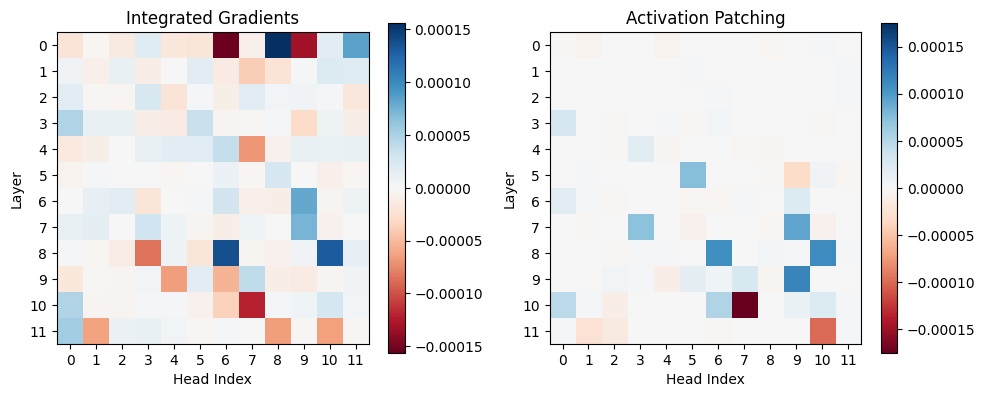

In [39]:
plot_attn_comparison(ig_attn_results, ap_attn_results, model)

In [47]:
import seaborn as sns
import numpy as np

def plot_correlation(x, y, x_label: str, y_label: str, title: str):
    assert x.size(0) == y.size(0)
    n_results = x.size(0)

    for i in range(n_results):
        xi = x[i].flatten().numpy()
        yi = y[i].flatten().numpy()
        sns.regplot(x=xi, y=yi)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(f"{title}")

        plt.tight_layout()
        plt.show()

        print(f"Correlation coefficient: {np.corrcoef(xi, yi)[0, 1]}")

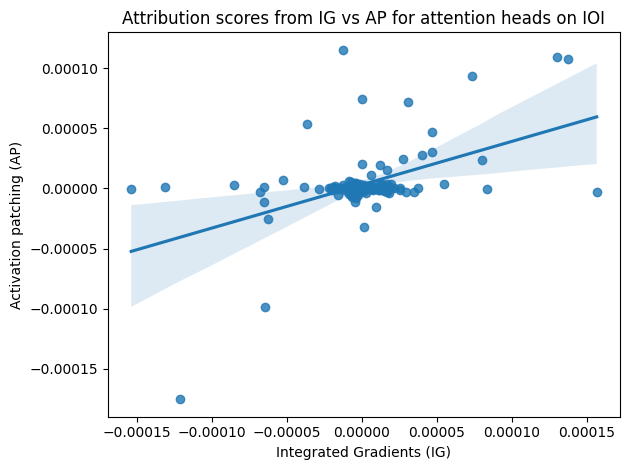

Correlation coefficient: 0.4884673573982641


In [48]:
plot_correlation(ig_attn_results, ap_attn_results, "Integrated Gradients (IG)", "Activation patching (AP)", "Attribution scores from IG vs AP for attention heads on IOI")

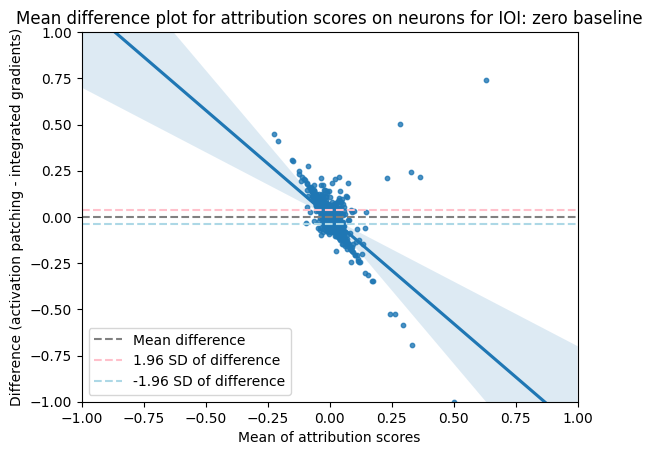

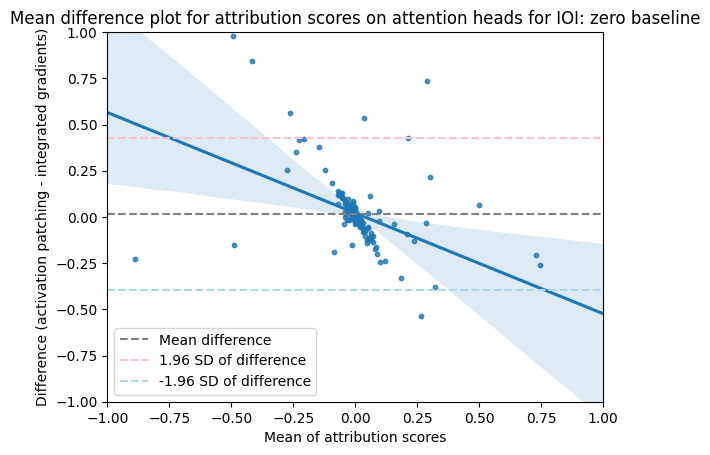

In [13]:
plot_mean_diff(ig_mlp_results, ap_mlp_results, "Mean difference plot for attribution scores on neurons for IOI: zero baseline")
plot_mean_diff(ig_attn_results, ap_attn_results, "Mean difference plot for attribution scores on attention heads for IOI: zero baseline")

### General results

In [ ]:
ig_attn_results = torch.load("results/initial/ig_attn_zero_results.pt")
ig_mlp_results = torch.load("results/initial/ig_mlp_zero_results.pt")

# Same runs as in experiment 4 with latent components, patching from corrupt to clean
ap_mlp_results = torch.load("results/aligned/ioi/ap_mlp.pt")
ap_attn_results = torch.load("results/aligned/ioi/ap_attn.pt")


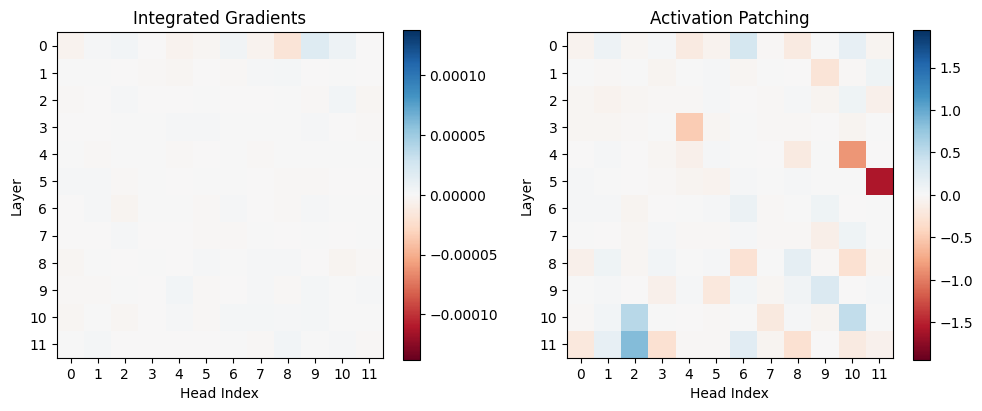

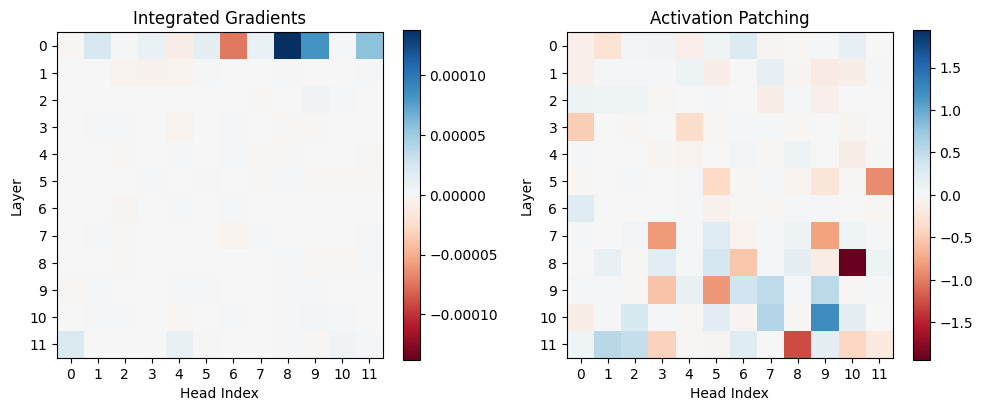

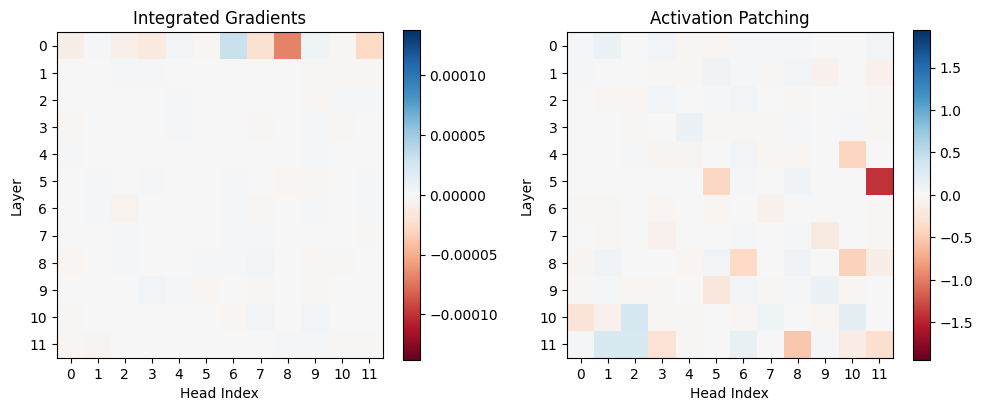

In [26]:
plot_attn_comparison(ig_attn_results[:3], ap_attn_results[:3], model)

In [27]:
# Mean and standard deviation
print(f"Mean attribution score for IG attention heads: {torch.mean(torch.mean(ig_attn_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for IG attention heads: {torch.mean(torch.std(ig_attn_results, dim=(1,2)))}")

print(f"Mean attribution score for IG MLP neurons: {torch.mean(torch.mean(ig_mlp_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for IG MLP neurons: {torch.mean(torch.std(ig_mlp_results, dim=(1,2)))}")

print(f"Mean attribution score for AP attention heads: {torch.mean(torch.mean(ap_attn_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for AP attention heads: {torch.mean(torch.std(ap_attn_results, dim=(1,2)))}")

print(f"Mean attribution score for AP MLP neurons: {torch.mean(torch.mean(ap_mlp_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for AP MLP neurons: {torch.mean(torch.std(ap_mlp_results, dim=(1,2)))}")

Mean attribution score for IG attention heads: 1.0464754041095148e-06
Standard deviation of attribution score for IG attention heads: 1.2027993761876132e-05
Mean attribution score for IG MLP neurons: 7.673540494579356e-06
Standard deviation of attribution score for IG MLP neurons: 0.0006883968599140644
Mean attribution score for AP attention heads: -0.019979096949100494
Standard deviation of attribution score for AP attention heads: 0.1870524138212204
Mean attribution score for AP MLP neurons: 3.160813503200188e-05
Standard deviation of attribution score for AP MLP neurons: 0.006862244103103876


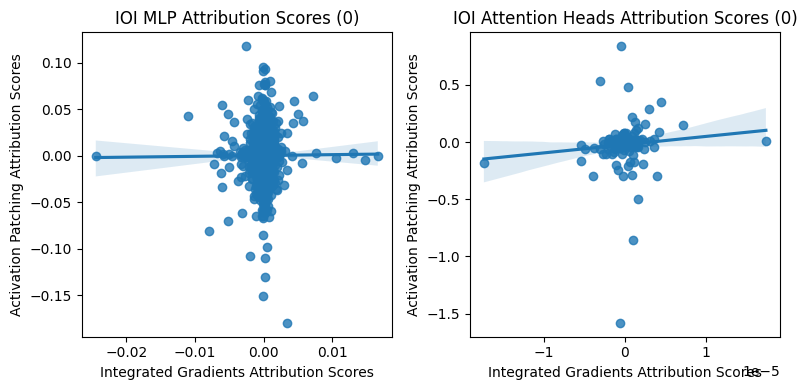

Correlation coefficient for neurons: 0.004602544348630095
Correlation coefficient for attention heads: 0.0967701704370072


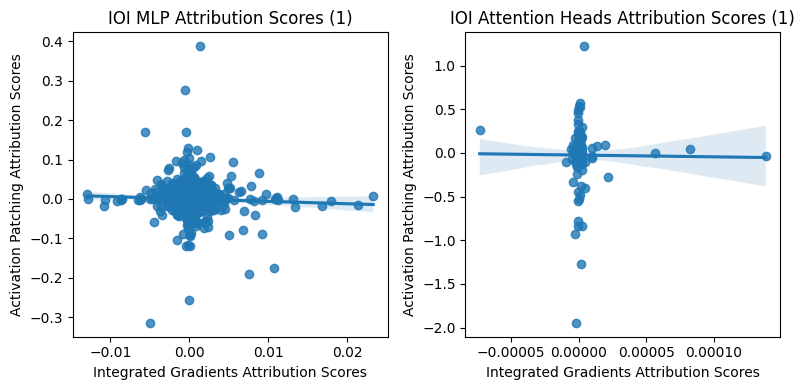

Correlation coefficient for neurons: -0.03673038208240532
Correlation coefficient for attention heads: -0.01029180716821932


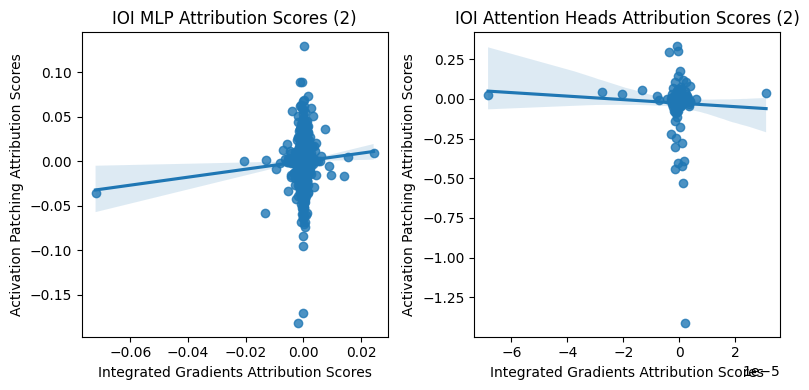

Correlation coefficient for neurons: 0.041665166590524966
Correlation coefficient for attention heads: -0.0495349038211753
Average correlation between MLP neuron scores: -0.018948969108584745
Standard deviation of correlation between MLP neuron scores: 0.05994366683723644
Average correlation between attention head scores: -0.05243368770503577
Standard deviation of correlation between attention head scores: 0.14876245156690188


In [28]:
plot_correlation_comparison(ig_mlp_results[:3], ap_mlp_results[:3], ig_attn_results[:3], ap_attn_results[:3], Task.IOI)

mlp_corr_avg, mlp_corr_std = average_correlation(ig_mlp_results, ap_mlp_results)
print(f"Average correlation between MLP neuron scores: {mlp_corr_avg}")
print(f"Standard deviation of correlation between MLP neuron scores: {mlp_corr_std}")

attn_corr_avg, attn_corr_std = average_correlation(ig_attn_results, ap_attn_results)
print(f"Average correlation between attention head scores: {attn_corr_avg}")
print(f"Standard deviation of correlation between attention head scores: {attn_corr_std}")

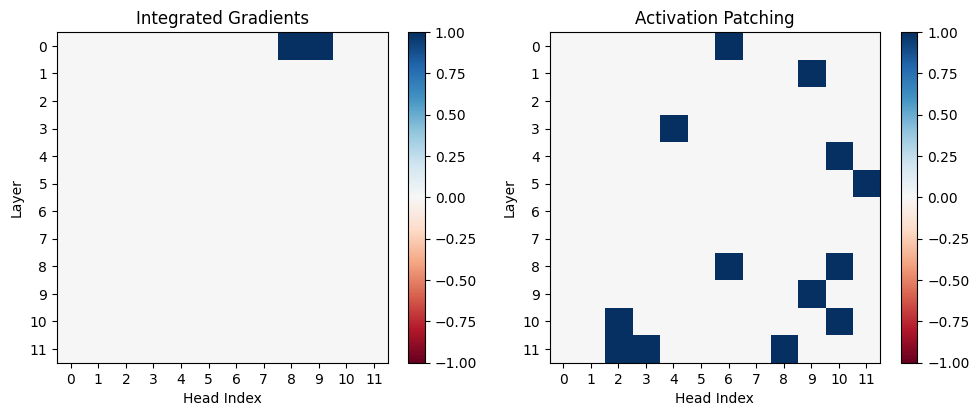

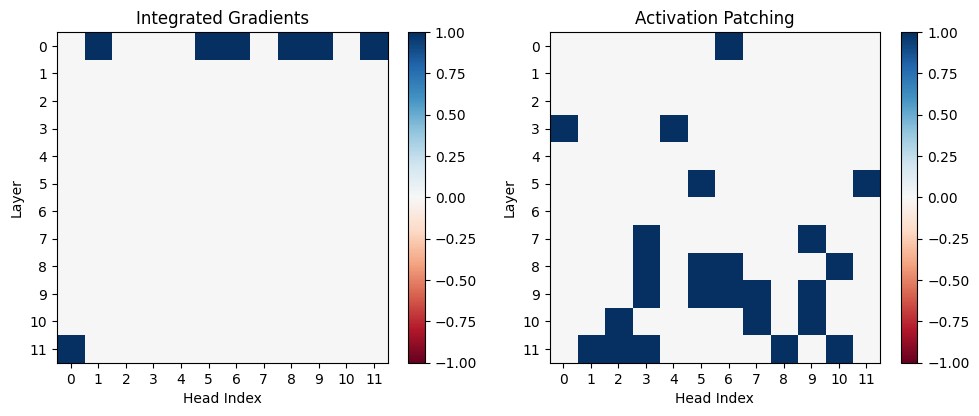

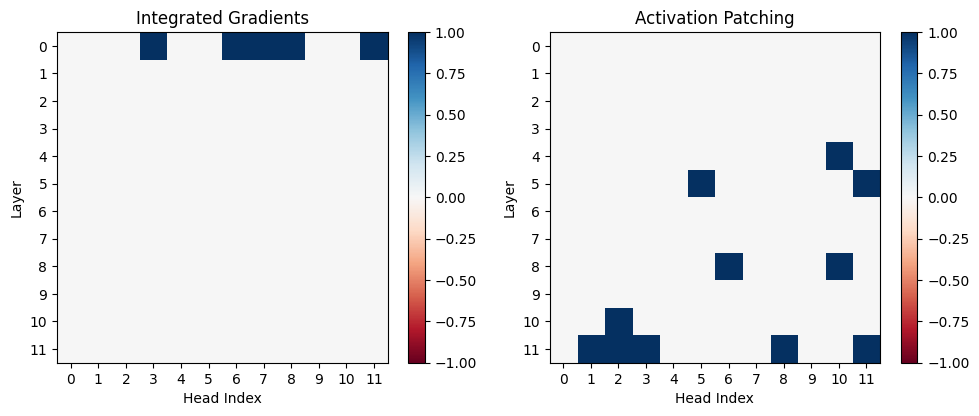

Average overlap between IG and AP highlighted attention heads: 0.04133494943380356


In [ ]:
ig_attn_significant, _ = highlight_components(ig_attn_results)
ap_attn_significant, _ = highlight_components(ap_attn_results)

plot_attn_comparison(ig_attn_significant[:3].int(), ap_attn_significant[:3].int(), model)

attn_overlap = measure_overlap(ig_attn_significant, ap_attn_significant)
print(f"Average overlap between IG and AP highlighted attention heads: {attn_overlap.mean()}")

In [ ]:
ig_mlp_significant, _ = highlight_components(ig_mlp_results)
ap_mlp_significant, _ = highlight_components(ap_mlp_results)

mlp_overlap = measure_overlap(ig_mlp_significant, ap_mlp_significant)
print(f"Average overlap between IG and AP highlighted MLP neurons: {mlp_overlap.mean()}")

Average overlap between IG and AP highlighted MLP neurons: 0.08510856330394745
